# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
!pip install phik -q
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import seaborn as sns

from phik import phik_matrix

from sklearn.preprocessing import(
    OrdinalEncoder,
    MinMaxScaler
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="interval columns not set")

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

/datasets/geo_data_0.csv

/datasets/geo_data_1.csv

/datasets/geo_data_2.csv

    id — уникальный идентификатор скважины;

    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

    product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Загрузка и первичный осмотр

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
for data in [geo_data_0, geo_data_1, geo_data_2]:
    display(data.head())
    print(data.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Данные в таблицах представлены корректно, а также не имеют пропусков

Теперь посмотрим, нет ли в таблицах дубликатов

In [4]:
for data in [geo_data_0, geo_data_1, geo_data_2]:
    print(data.duplicated().sum())

0
0
0


Явных дубликатов в данных точно нет

Посмотрим, сколько уникальных *id* есть во всех трёх таблицах

In [5]:

for data in [geo_data_0, geo_data_1, geo_data_2]:
    print(f'Общее количество строк:{data.shape[0]}  Количество уникальных id:{data["id"].nunique()}')

Общее количество строк:100000  Количество уникальных id:99990
Общее количество строк:100000  Количество уникальных id:99996
Общее количество строк:100000  Количество уникальных id:99996


Оказывается, в данных присутствуют повторяющиеся скважины. Избавимся от повторов

In [6]:
geo_data_0.drop_duplicates(subset='id', keep='first', inplace=True)
geo_data_1.drop_duplicates(subset='id', keep='first', inplace=True)
geo_data_2.drop_duplicates(subset='id', keep='first', inplace=True)

### Исследовательский анализ

Так как нам неизвестно, что скрывают за собой входящие признаки, просто посмотрим на их распределение

In [7]:
def dist_plots(data):
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    
    cols = data.columns.drop('id')
    for i in range(len(cols)):
        sns.boxplot(data[cols[i]], orient='v', ax=axs[i])
        axs[i].set_title(f'Распределение признака {cols[i]}')
    plt.show();
    print('\n\n')

Распределение признаков в первом регионе


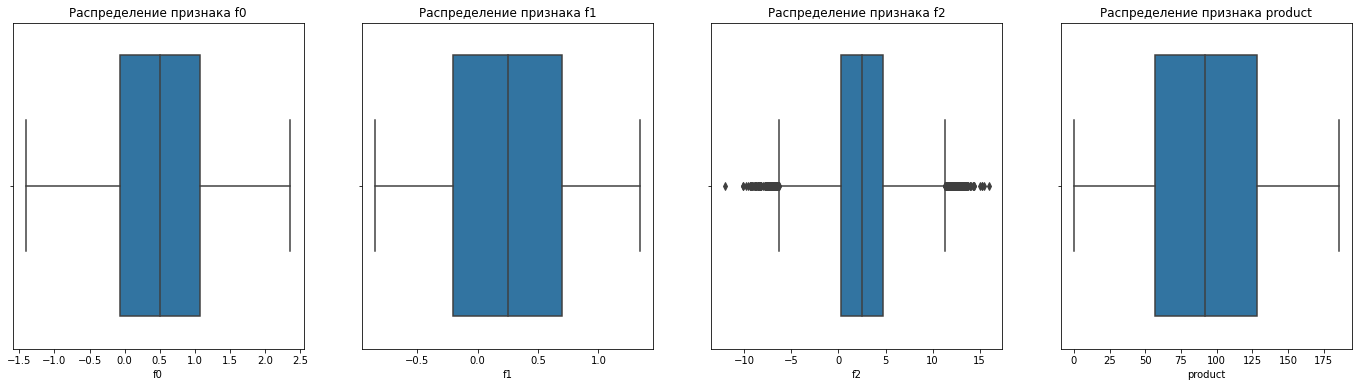




Распределение признаков во втором регионе


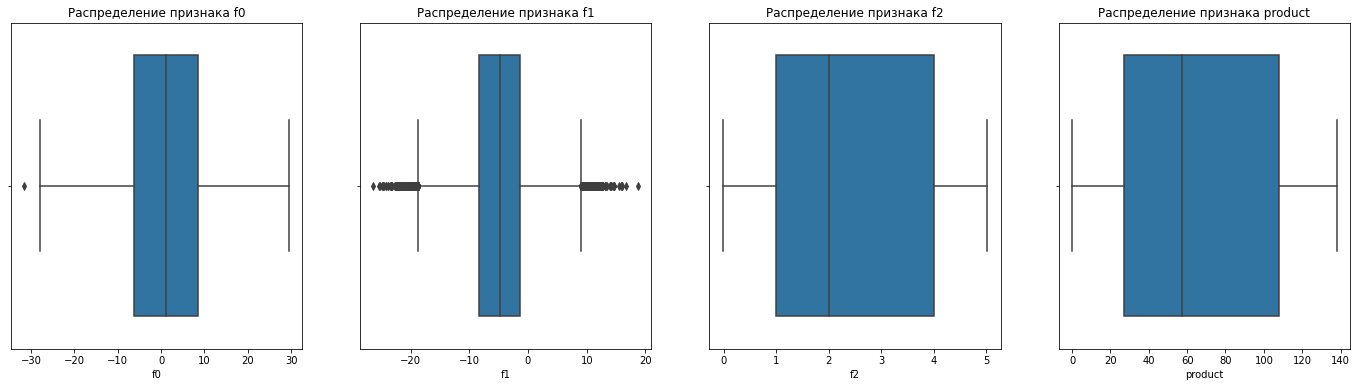




Распределение признаков в третьем регионе


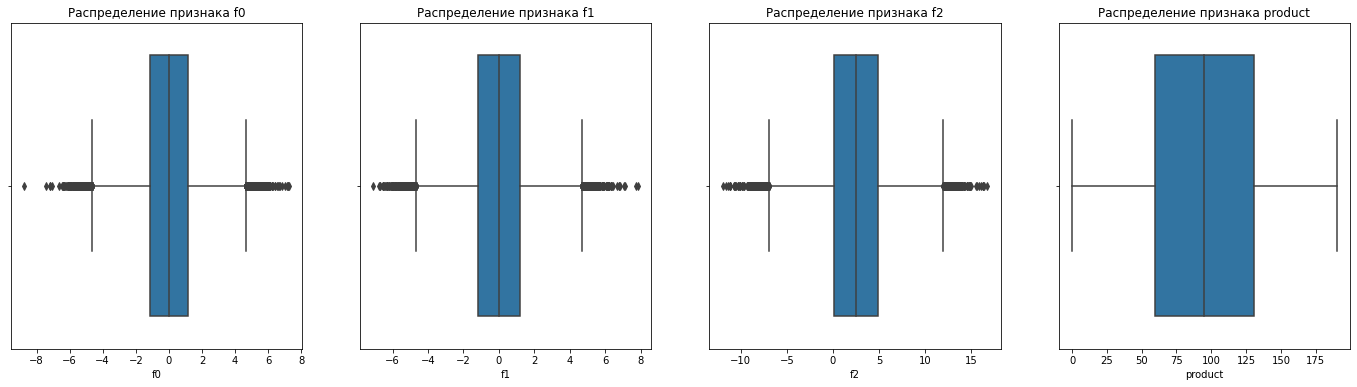

In [8]:
print('Распределение признаков в первом регионе')
dist_plots(geo_data_0)

print('Распределение признаков во втором регионе')
dist_plots(geo_data_1)

print('Распределение признаков в третьем регионе')
dist_plots(geo_data_2)

Оказывается, данные в наших таблицах сильно отличаются:

**В первой таблице**:

- входные признаки отличаются небольшим распределением

**Во второй таблице**:

- признаки *f1* и *f0* имеют большое распределение, в то время как *f2* обладает самым малым распределением среди всех признаков трёх датасетов
- самое низкое среднее значение *product*

**В третьей таблице**:

- входные признаки отличаются средним распределением и большим количесвом выбросов

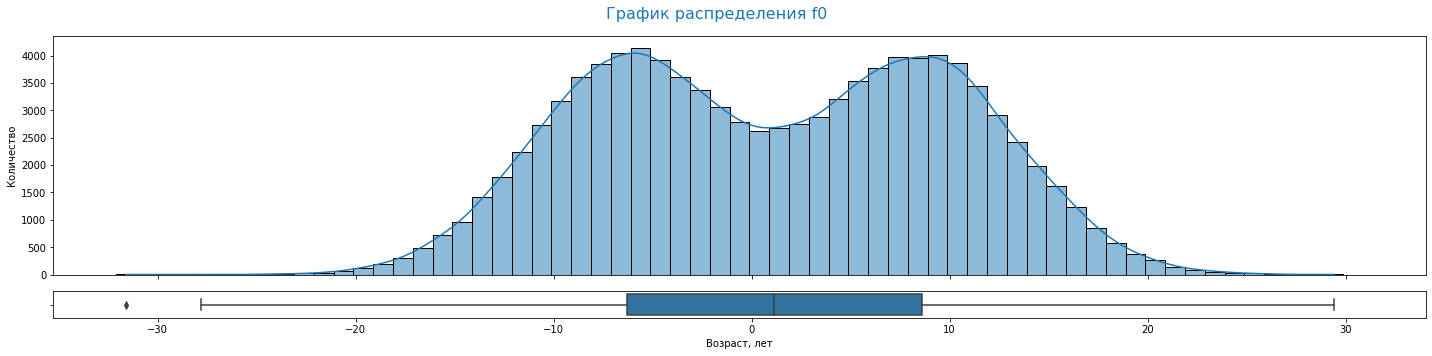

In [9]:
fig, (ax_main, ax_box) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (.9, .1)}
)
fig.set_size_inches((20, 5))
sns.histplot(x=geo_data_1['f0'], kde=True, discrete=True, ax=ax_main).set(ylabel="Количество")
sns.boxplot(x=geo_data_1['f0'], ax=ax_box)
plt.suptitle("График распределения f0", size=16, color="C0")
plt.xlabel("Возраст, лет")
plt.tight_layout()
plt.show()

### Подготовка данных

Теперь определимся с тем, как будем обрабатывать признаки:

- для кодирования *id* мы будем использовать OrdinalEncoder, так как столбец содержит слишком много уникальных значений
- *f0*, *f1*, *f2*, *product* будут нормализованы с помощью MinMaxScaler

In [10]:
num_cols = ['f0', 'f1', 'f2']

Теперь подготовим данные таблиц к работе с моделью МО

In [11]:
# кодирование id
encoder = OrdinalEncoder()

pgdata0 = geo_data_0.copy()
pgdata1 = geo_data_1.copy()
pgdata2 = geo_data_2.copy()

pgdata0['id'] = encoder.fit_transform(np.array(pgdata0['id']).reshape(-1, 1))
pgdata1['id'] = encoder.fit_transform(np.array(pgdata1['id']).reshape(-1, 1))
pgdata2['id'] = encoder.fit_transform(np.array(pgdata2['id']).reshape(-1, 1))

In [12]:
# нормализация количественных признаков
# scaler = MinMaxScaler()

# pgdata0[num_cols] = scaler.fit_transform(pgdata0[num_cols])
# pgdata1[num_cols] = scaler.fit_transform(pgdata1[num_cols])
# pgdata2[num_cols] = scaler.fit_transform(pgdata2[num_cols])

Так как само *id* не может влиять на объём запасов нефти, сделаем его индексом таблиц

In [13]:
pgtables = [pgdata0, pgdata1, pgdata2]
for data in pgtables:
    data.set_index('id', inplace=True)
    data.index = data.index.astype(int)

### Корреляционный анализ

Теперь узнаем, как взаимосвязаны переменные в таблицах

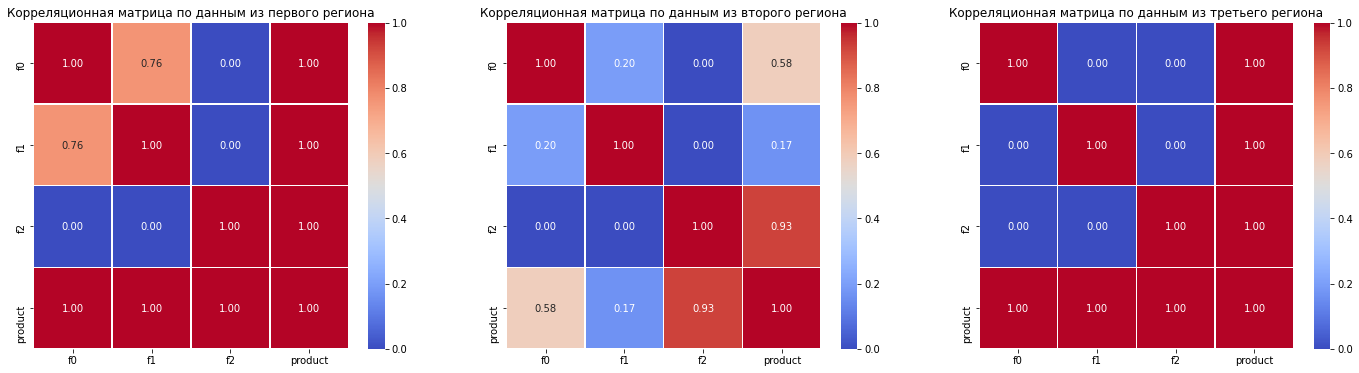

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
table_labels = ['первого региона', 'второго региона', 'третьего региона']

for i in range(len(pgtables)):
    corr_matrix = pgtables[i].phik_matrix(interval_cols=['f0', 'f1', 'f2'])
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axs[i])
    axs[i].set_title(f'Корреляционная матрица по данным из {table_labels[i]}')
plt.show();

Какие выводы можно сделать из этих тепловых карт:

**Первый регион**:

- наблюдается 100%-ая корреляция между целевой переменной(*product*) и входными признаками
- f1 и f0 имеют высокую корреляцию между друг другом, однако её недостаточно для того, чтобы говорить о мультиколлинеарности

**Второй регион**:

- целевой признак имеет сильную корреляцию с f2 и среднюю с f0, а значение f1 практически никак не связано с таргетом

**Третий регион**:

- идеальная корреляционная карта: таргет имеет 100%-ую корреляцию с входными признаками
- входные признаки никак не коррелируют между собой

**В резултате загрузки и подготовки данных**:

- были загружены таблицы **geo_data_0**, **geo_data_1**, **geo_data_2**
- выявлено различное распределение данных в трёх таблицах
- были удалены дубликаты по *id*
- был закодирован *id*
- произведён корреляционный анализ всех трёх таблиц

## Обучение и проверка модели

Сделаем функцию, которая будет обучать модель на представленных данных и выводить её результаты и правильные ответы на валидационной выборке

In [15]:
RANDOM_STATE=42
def model_train_predict(pgdata):
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        pgdata.drop('product', axis=1),
        pgdata['product'],
        test_size=0.25,
        random_state=RANDOM_STATE
    )
    # нормализация количественных признаков
    scaler = MinMaxScaler()

    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_valid[num_cols] = scaler.transform(X_valid[num_cols])
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    preds = model.predict(X_valid)
    print('Cредний запас предсказанного сырья:', preds.mean())
    print('RMSE модели:', mean_squared_error(preds, y_valid)**0.5)

    return model, preds, X_valid.merge(y_valid, on='id')

In [16]:
print('Первый регион')
model0, hole0, valid_data0 = model_train_predict(pgdata0)
print()

print('Второй регион')
model1, hole1, valid_data1 = model_train_predict(pgdata1)
print()

print('Третий регион')
model2, hole2, valid_data2= model_train_predict(pgdata2)

Первый регион
Cредний запас предсказанного сырья: 92.60984027552014
RMSE модели: 37.68508926201444

Второй регион
Cредний запас предсказанного сырья: 68.57703454115173
RMSE модели: 0.8928265978121425

Третий регион
Cредний запас предсказанного сырья: 94.93478722287517
RMSE модели: 40.080822438088305


Модель отлично предсказывает объём нефти во втором регионе(ошибка меньше 1тыс. баррелей), однако в нём самые малые запасы нефти. В то же время в первом и третьем регионе залежи содержат в полтора раза больше нефти, однако у модели линейной регрессии очень плохо получается предсказывать значения в этих регионах(она ошибается в среднем на 39 тыс. баррелей)

## Подготовка к расчёту прибыли

Cохраним ключевые значения для расчётов в переменных

In [17]:
REGION_BUDGET = 10**10
BUDGET = REGION_BUDGET / 200 # Бюджет на разработку каждой скважины в регионе
INCOME_PER_BAR = 450000 # Доход с каждой единицы продукта

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [18]:
min_product = round(BUDGET / INCOME_PER_BAR, 2)
min_product

111.11

Получается, что 112 тыс. баррелей сырья должно хватить для безубыточной работы

Сравним полученный объём сырья со средним запасом в каждом регионе и посмотрим, сколько точек в каждом регионе cможет принести деньги компании

In [19]:
print('Первый регион')
print('Средний объём сырья в точках:', pgdata0['product'].mean())
print(f'Количество прибыльных точек: {pgdata0[pgdata0["product"] > 112].shape[0]}', end='\n\n')

print('Второй регион')
print('Средний объём сырья в точках:', pgdata1['product'].mean())
print(f'Количество прибыльных точек: {pgdata1[pgdata1["product"] > 112].shape[0]}', end='\n\n')

print('Третий регион')
print('Средний объём сырья в точках:', pgdata2['product'].mean())
print(f'Количество прибыльных точек: {pgdata2[pgdata2["product"] > 112].shape[0]}', end='\n\n')

Первый регион
Средний объём сырья в точках: 92.49968421774354
Количество прибыльных точек: 35897

Второй регион
Средний объём сырья в точках: 68.82391591804064
Количество прибыльных точек: 16536

Третий регион
Средний объём сырья в точках: 94.99834211933378
Количество прибыльных точек: 37488



Средний объём сырья в скважинах меньше достаточного для прибыли. В то же время, выходит, что в каждом региое есть более 15 тысяч прибыльных точек, однако во втором регионе их вдвое меньше, чем в остальных. Следовательно, следует анализировать и разрабатывать только те точки, которые обладают большими запасами

### Функция для расчёта прибыли

Для разработки выберем 200 самых богатых сырьём скважин и посчитаем, какую прибыль они принесут компании

In [20]:
# функцию для расчёта прибыли по выбранным скважинам и предсказаниям
def pred_hole_profit(model, hole):
    pred = model.predict(hole.drop('product', axis=1))
    hole['preds'] = pred
    return (round(sum(hole.sort_values(by='preds', ascending=False)['product'][:200]), 2) * INCOME_PER_BAR) - REGION_BUDGET

**В результате подготовки к расчёту прибыли было выявлено, что**:

- для безубыточной торговли скважина должна приносить 112(111.11)тыс. баррелей сырья
- среднего объёма нефти, которую приносят скважины в каждом регионе, не хватает для того, чтобы покрыть расходы на их разработку
- в первом и третьем регионах есть более 35тыс. прибыльных точек, в то время как во втором регионе их 16тыс
- была сделана функция для подсчёта прибыли с месторождений в регионе

## Расчёт рисков и прибыли

Произведём расчёт рисков добычи сырья в трёх регионах, а также узнаем, какую прибыль может принести разработка месторождений

Для этого создадим функцию, которая будет с помощью техники Bootstrap показывать среднюю выручку со скважин, 95%-й доверительный интервал и вероятность того, что точка будет убыточной

In [21]:
def risks_and_profit_of_region(model, data):
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        # берём только 500 месторождений для разведки
        subsample = data.sample(n=500, replace=True, random_state=state)
        values.append(pred_hole_profit(model, subsample))
    
    values = pd.Series(values)
    mean_value = values.mean()
    lower_bound = values.quantile(0.025)
    upper_bound = values.quantile(0.975)
    loss_risk = np.mean(values < 0) * 100
    
    plt.figure(figsize=(14, 8))
    sns.histplot(values, kde=True, color='skyblue', bins=20)
    plt.axvline(mean_value, color='red', linestyle='--', label=f'Средняя выручка: {mean_value:.2f}')
    plt.axvline(lower_bound, color='green', linestyle=':', label=f'95% Нижний интервал: {lower_bound:.2f}')
    plt.axvline(upper_bound, color='green', linestyle=':', label=f'95% Верхний интервал: {upper_bound:.2f}')
    plt.xlabel('Выручка')
    plt.ylabel('Количество')
    plt.legend(loc='upper right')
    plt.show();
    
    print("Средняя выручка:", mean_value)
    print(f"95%-й доверительный интервал: {lower_bound:.0f} — {upper_bound:.0f}")
    print(f"Риск убытков: {loss_risk:.2f}%")

Первый регион


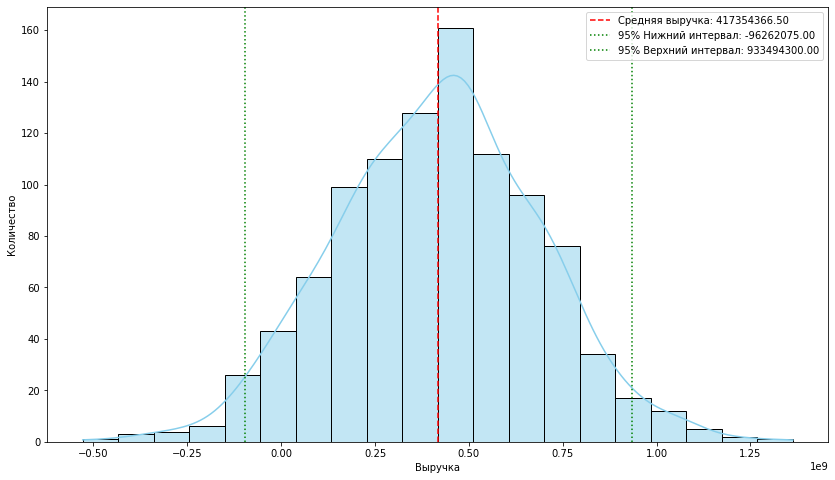

Средняя выручка: 417354366.5
95%-й доверительный интервал: -96262075 — 933494300
Риск убытков: 5.90%


Второй регион


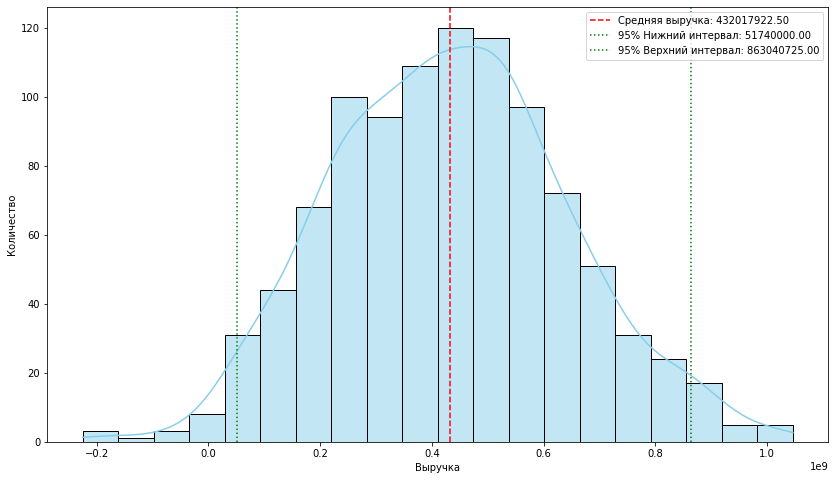

Средняя выручка: 432017922.5
95%-й доверительный интервал: 51740000 — 863040725
Риск убытков: 1.00%


Третий регион


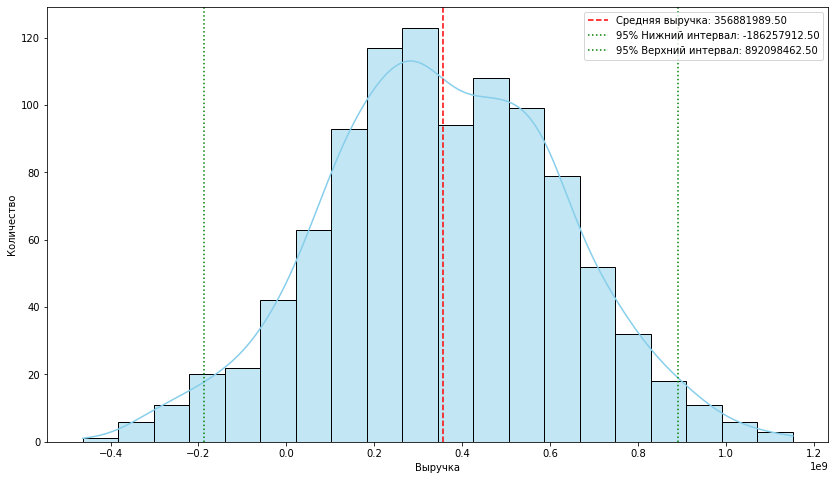

Средняя выручка: 356881989.5
95%-й доверительный интервал: -186257912 — 892098462
Риск убытков: 8.90%


In [22]:
print('Первый регион')
risks_and_profit_of_region(model0, valid_data0)

print('\n\nВторой регион')
risks_and_profit_of_region(model1, valid_data1)

print('\n\nТретий регион')
risks_and_profit_of_region(model2, valid_data2)

В результате расчёта рисков оказалось, что только второй регион имеет риск убытков меньше 2.5%. Кроме того, именно в этом регионе самая большая средняя выручка.

Таким образом, для разработки месторождения лучше всего подходит именно второй регион

**Важно:**

На исследование сильно влияют предсказания модели линейной регрессии, которая слабо показала себя в предсказании объёма месторождений в третьем и первом регионах. Так что, по возможности, модель следует заменить на более сильную

## Вывод

В результате анализа возможной прибыли и рисков в разработке месторождений трёх регионов с помощью модели МО было выявлено, что второй регион лучше всего подходит для разработки месторождения. Остальные регионы имеют более высокий риск убытков.